In [328]:
%load_ext autoreload
%autoreload 2

import SimulationManager
#import bookExample


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


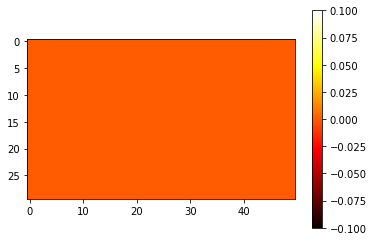

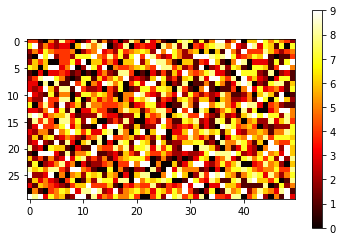

ae	 [-1000. -1000. -1000. ... -1000. -1000.     0.]
aw	 [    0. -1000. -1000. ... -1000. -1000. -1000.]
an	 [    0.     0.     0. ... -1000. -1000. -1000.]
as	 [-1000. -1000. -1000. ...     0.     0.     0.]
ap	 [4000. 3000. 3000. ... 3000. 3000. 4000.]
s	 [ 200000.       0.       0. ...       0.       0. 1000000.]
[[ 4000. -1000.     0. ...     0.     0.     0.]
 [-1000.  3000. -1000. ...     0.     0.     0.]
 [    0. -1000.  3000. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ...  3000. -1000.     0.]
 [    0.     0.     0. ... -1000.  3000. -1000.]
 [    0.     0.     0. ...     0. -1000.  4000.]]
[ 200000.       0.       0. ...       0.       0. 1000000.]
[[104. 112. 120. ... 480. 488. 496.]
 [104. 112. 120. ... 480. 488. 496.]
 [104. 112. 120. ... 480. 488. 496.]
 ...
 [104. 112. 120. ... 480. 488. 496.]
 [104. 112. 120. ... 480. 488. 496.]
 [104. 112. 120. ... 480. 488. 496.]]


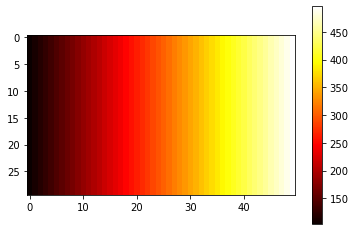

In [329]:
# no data here. only void functions

sim = SimulationManager.simulation()

sim.prepSim()
sim.execute()

